In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, date_format, weekofyear, month, quarter, year
import os
from pyspark.sql.types import *
import requests
import psutil
from datetime import datetime, timedelta
import glob
import time
from pyspark.sql.functions import col, count, when
from pyspark.sql import functions as F
from pyspark.sql import SparkSession, functions as F, Window
from pyspark.sql.functions import broadcast
import shutil
from pyspark.sql import SparkSession, functions as F
from google.cloud import bigquery
import pyarrow.parquet as pq
import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions, GoogleCloudOptions, SetupOptions, StandardOptions
from google.cloud import storage
import tempfile




In [2]:
num_cores = psutil.cpu_count(logical=False)  
# --> Counts the number of physical CPU cores / Conta o número de núcleos físicos de CPU <--

NUM_PARTITIONS = max(num_cores * 2, 16)  
# --> Sets the number of partitions for the Spark job, based on the number of cores, with a minimum of 16 partitions / Define o número de partições para o trabalho do Spark, baseado no número de núcleos, com um mínimo de 16 partições <--

print(f"Número de partições ajustado para: {NUM_PARTITIONS}")  
num_cores

Número de partições ajustado para: 16


8

In [3]:
# INICIAR SESSÃO SPARK COM OTIMIZAÇÕES PARA O MAC M2 (8GB RAM)
spark = SparkSession.builder \
    .appName("Corrigir_Parquet") \
    .config("spark.sql.shuffle.partitions", str(NUM_PARTITIONS)) \
    .config("spark.default.parallelism", "6") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.memory.fraction", "0.80") \
    .config("spark.memory.storageFraction", "0.5") \
    .config("spark.sql.files.maxPartitionBytes", "128MB") \
    .config("spark.cleaner.referenceTracking.cleanCheckpoints", "false") \
    .config("spark.executor.heartbeatInterval", "60000ms") \
    .config("spark.task.cpus", "1") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .master("local[*]") \
    .getOrCreate()

# REDUZIR LOGS PARA EVITAR POLUIÇÃO NO CONSOLE
spark.sparkContext.setLogLevel("ERROR")

print("\n SparkSession configurada com sucesso!")

25/04/08 16:37:35 WARN Utils: Your hostname, Mac.local resolves to a loopback address: 127.0.0.1; using 192.168.0.213 instead (on interface en0)
25/04/08 16:37:35 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/08 16:37:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/08 16:37:37 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.



 SparkSession configurada com sucesso!


In [4]:
PATH_BLOCKS = "/Users/rodrigocampos/Library/Mobile Documents/com~apple~CloudDocs/processed_data/blockchain_blocks_part"
PATH_TRANSACTIONS = "/Users/rodrigocampos/Library/Mobile Documents/com~apple~CloudDocs/processed_data/blockchain_transactions_part"
PATH_ADDRESSES = "/Users/rodrigocampos/Library/Mobile Documents/com~apple~CloudDocs/processed_data/blockchain_addresses_part"
SAVE_PATH = "/Users/rodrigocampos/Library/Mobile Documents/com~apple~CloudDocs/bitcoin_features/features_temp/df_bitcoin_features.parquet"
METADATA_PATH = "/Users/rodrigocampos/Library/Mobile Documents/com~apple~CloudDocs/processed_data/metadata.txt"
USD_PATH = "/Users/rodrigocampos/Library/Mobile Documents/com~apple~CloudDocs/bitcoin_features/features_dolar_parquet"

In [5]:
df_blocks = spark.read.parquet(PATH_BLOCKS)
df_transactions = spark.read.parquet(PATH_TRANSACTIONS)
df_addresses = spark.read.parquet(PATH_ADDRESSES)
# df_blocks_features = spark.read.parquet(SAVE_PATH)
# df_price_dolar = spark.read.parquet(USD_PATH)


In [6]:
menor_bloco = df_blocks.select("block_height").orderBy("block_height").first()[0]  
# --> Gets the minimum block height by ordering the 'block_height' column in ascending order / Obtém a altura mínima do bloco ordenando a coluna 'block_height' em ordem crescente <--

maior_bloco = df_blocks.select("block_height").orderBy(F.desc("block_height")).first()[0]  
# --> Gets the maximum block height by ordering the 'block_height' column in descending order / Obtém a altura máxima do bloco ordenando a coluna 'block_height' em ordem decrescente <--

print(f"Menor bloco salvo: {menor_bloco}")  
# --> Prints the minimum block height / Imprime a altura mínima do bloco <--

print(f"Maior bloco salvo: {maior_bloco}")  
# --> Prints the maximum block height / Imprime a altura máxima do bloco <--

Menor bloco salvo: 889527
Maior bloco salvo: 891536


In [7]:
df_blocks.printSchema()

root
 |-- block_height: long (nullable = true)
 |-- block_timestamp: timestamp (nullable = true)
 |-- block_hash: string (nullable = true)
 |-- num_transactions: long (nullable = true)
 |-- total_btc_moved: double (nullable = true)
 |-- block_reward: double (nullable = true)
 |-- total_fees: double (nullable = true)
 |-- block_value_btc: double (nullable = true)
 |-- prev_block_height: long (nullable = true)
 |-- prev_timestamp: timestamp_ntz (nullable = true)
 |-- time_diff: long (nullable = true)
 |-- halving_period: integer (nullable = true)
 |-- calculated_block_value: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)



In [ ]:
df_blocks_clean = df_blocks.dropDuplicates()  
# --> Removes duplicate rows from 'df_blocks' DataFrame / Remove as linhas duplicadas do DataFrame 'df_blocks' <--

df_transactions_clean = df_transactions.dropDuplicates()  
# --> Removes duplicate rows from 'df_transactions' DataFrame / Remove as linhas duplicadas do DataFrame 'df_transactions' <--

df_addresses_clean = df_addresses.dropDuplicates()  
# --> Removes duplicate rows from 'df_addresses' DataFrame / Remove as linhas duplicadas do DataFrame 'df_addresses' <--

num_duplicates_blocks = df_blocks_clean.groupBy(df_blocks_clean.columns).count().filter(F.col("count") > 1).count()  
# --> Counts the number of duplicate rows in the 'df_blocks_clean' DataFrame / Conta o número de linhas duplicadas no DataFrame 'df_blocks_clean' <--

num_duplicates_transactions = df_transactions_clean.groupBy(df_transactions_clean.columns).count().filter(F.col("count") > 1).count()  
# --> Counts the number of duplicate rows in the 'df_transactions_clean' DataFrame / Conta o número de linhas duplicadas no DataFrame 'df_transactions_clean' <--

num_duplicates_addresses = df_addresses_clean.groupBy(df_addresses_clean.columns).count().filter(F.col("count") > 1).count()  
# --> Counts the number of duplicate rows in the 'df_addresses_clean' DataFrame / Conta o número de linhas duplicadas no DataFrame 'df_addresses_clean' <--

print(f"Blocos duplicados: {num_duplicates_blocks}")  
# --> Prints the number of duplicate blocks / Imprime o número de blocos duplicados <--

print(f"Transações duplicadas: {num_duplicates_transactions}")  
# --> Prints the number of duplicate transactions / Imprime o número de transações duplicadas <--

print(f"Endereços duplicados: {num_duplicates_addresses}")  
# --> Prints the number of duplicate addresses / Imprime o número de endereços duplicados <--

In [10]:
LAST_UPDATE_FILE = "/Users/rodrigocampos/Library/Mobile Documents/com~apple~CloudDocs/bitcoin_features/last_update.txt"  
# --> Path to the file where the last update timestamp will be saved / Caminho para o arquivo onde a data do último update será salva <--

df_blocks = spark.read.parquet(PATH_BLOCKS)  
# --> Reads the 'blockchain_blocks' Parquet file into a Spark DataFrame / Lê o arquivo Parquet 'blockchain_blocks' para um DataFrame do Spark <--

min_date = df_blocks.agg(F.min("block_timestamp")).collect()[0][0]  
# --> Gets the minimum timestamp (oldest date) from the 'block_timestamp' column / Obtém o timestamp mínimo (data mais antiga) da coluna 'block_timestamp' <--

if min_date:  
    # --> If a valid minimum date is found / Se uma data mínima válida for encontrada <--
    min_date_str = min_date.strftime("%Y-%m-%d %H:%M:%S")  
    # --> Converts the date to a string format / Converte a data para o formato de string <--

    with open(LAST_UPDATE_FILE, "w") as f:  
        # --> Opens the file to write the date string / Abre o arquivo para escrever a string da data <--
        f.write(min_date_str)  

    print(f"Data mais antiga ({min_date_str}) salva em {LAST_UPDATE_FILE}")  
    # --> Prints the saved oldest date to the console / Imprime a data mais antiga salva no console <--
else:  
    print("Erro: Nenhuma data encontrada no DataFrame.")  
    # --> Prints an error message if no date was found / Imprime uma mensagem de erro se nenhuma data for encontrada <--

Data mais antiga (2025-03-26 12:37:41) salva em /Users/rodrigocampos/Library/Mobile Documents/com~apple~CloudDocs/bitcoin_features/last_update.txt


In [11]:
now = datetime.utcnow()  
# --> Gets the current UTC time / Obtém o horário atual em UTC <--

three_days_ago = now - timedelta(days=3)  
# --> Calculates the timestamp for three days ago / Calcula o timestamp de três dias atrás <--

COINGECKO_API_URL = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart/range"  
# --> Base URL for the CoinGecko API to fetch historical market data / URL base da API CoinGecko para buscar dados históricos de mercado <--

PARAMS = {  
    "vs_currency": "usd",  
    # --> Sets the currency for the price data to USD / Define a moeda para os dados de preço como USD <--
    "from": int(three_days_ago.timestamp()),  
    # --> Sets the starting timestamp for the query (3 days ago) / Define o timestamp de início da consulta (3 dias atrás) <--
    "to": int(now.timestamp())  
    # --> Sets the end timestamp for the query (current time) / Define o timestamp final da consulta (hora atual) <--
}

response = requests.get(COINGECKO_API_URL, params=PARAMS)  
# --> Sends a GET request to the CoinGecko API to fetch market chart data / Envia uma solicitação GET para a API CoinGecko para buscar dados do gráfico de mercado <--

data = response.json()  
# --> Parses the JSON response from the API / Analisa a resposta JSON da API <--

df = pd.DataFrame(data["prices"], columns=["timestamp", "price"])  
# --> Converts the data into a DataFrame with columns for timestamp and price / Converte os dados em um DataFrame com as colunas de timestamp e preço <--

df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")  
# --> Converts the timestamp from milliseconds to a readable datetime format / Converte o timestamp de milissegundos para um formato de data e hora legível <--

df["time_diff"] = df["timestamp"].diff()  
# --> Calculates the difference between consecutive timestamps / Calcula a diferença entre timestamps consecutivos <--

print(df.head(10))  
# --> Prints the first 10 rows of the DataFrame / Imprime as primeiras 10 linhas do DataFrame <--

print(df["time_diff"].value_counts())  
# --> Prints the count of each unique time difference / Imprime a contagem de cada diferença de tempo única <--

/var/folders/q4/msgggjcn0c9448__nbm848r00000gn/T/ipykernel_21837/3797415931.py:1: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.utcnow()


                timestamp         price              time_diff
0 2025-04-05 23:04:48.207  83167.517929                    NaT
1 2025-04-06 00:04:52.197  83514.338244 0 days 01:00:03.990000
2 2025-04-06 01:04:52.044  83478.355581 0 days 00:59:59.847000
3 2025-04-06 02:00:54.662  83397.091908 0 days 00:56:02.618000
4 2025-04-06 03:04:43.792  83276.110761 0 days 01:03:49.130000
5 2025-04-06 04:04:48.480  83315.283342 0 days 01:00:04.688000
6 2025-04-06 05:04:45.972  83466.045514 0 days 00:59:57.492000
7 2025-04-06 06:04:53.790  83417.470287 0 days 01:00:07.818000
8 2025-04-06 07:04:52.241  83089.491114 0 days 00:59:58.451000
9 2025-04-06 08:02:20.660  82975.834111 0 days 00:57:28.419000
time_diff
0 days 01:00:03.990000    1
0 days 01:00:07.931000    1
0 days 00:39:07.518000    1
0 days 01:20:44.430000    1
0 days 01:00:09.060000    1
                         ..
0 days 00:32:38.200000    1
0 days 01:06:31.908000    1
0 days 00:56:57.787000    1
0 days 01:00:49.356000    1
0 days 00:59:54.2

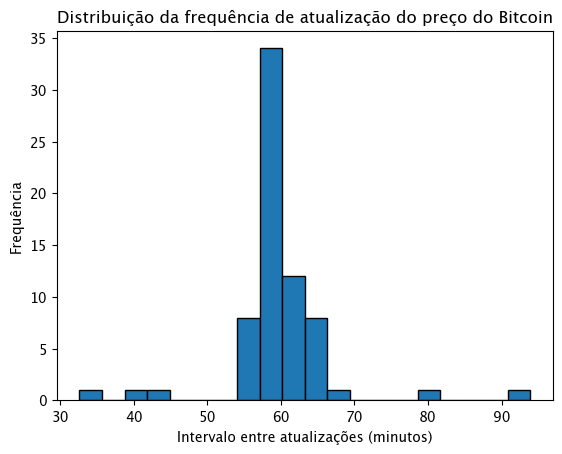

In [12]:
df["time_diff_minutes"] = df["time_diff"].dt.total_seconds() / 60  
# --> Converts the time difference from seconds to minutes / Converte a diferença de tempo de segundos para minutos <--

plt.hist(df["time_diff_minutes"], bins=20, edgecolor="black")  
# --> Creates a histogram to visualize the distribution of time differences / Cria um histograma para visualizar a distribuição das diferenças de tempo <--

plt.xlabel("Intervalo entre atualizações (minutos)")  
# --> Labels the x-axis with the time difference in minutes / Rotula o eixo x com a diferença de tempo em minutos <--

plt.ylabel("Frequência")  
# --> Labels the y-axis with the frequency of each time interval / Rotula o eixo y com a frequência de cada intervalo de tempo <--

plt.title("Distribuição da frequência de atualização do preço do Bitcoin")  
# --> Adds a title to the histogram / Adiciona um título ao histograma <--

plt.show()  
# --> Displays the histogram / Exibe o histograma <--

In [13]:
import os
import requests
import pandas as pd
from datetime import datetime, timedelta
import glob


PARQUET_PATH = "/Users/rodrigocampos/Library/Mobile Documents/com~apple~CloudDocs/bitcoin_features/features_dolar_parquet"
LAST_UPDATE_FILE = "/Users/rodrigocampos/Library/Mobile Documents/com~apple~CloudDocs/bitcoin_features/last_update.txt"

def get_last_saved_date():
    if os.path.exists(LAST_UPDATE_FILE):
        with open(LAST_UPDATE_FILE, "r") as f:
            date_str = f.read().strip()
            return pd.to_datetime(date_str) if date_str else None
    return None
    # --> Reads the last saved date from a file / Lê a última data salva de um arquivo <--

def update_last_saved_date(date):
    with open(LAST_UPDATE_FILE, "w") as f:
        f.write(date.strftime("%Y-%m-%d %H:%M:%S"))
    # --> Updates the last saved date to the file / Atualiza a última data salva no arquivo <--

last_saved_date = get_last_saved_date()
print(f"Última data salva: {last_saved_date}")
# --> Prints the last saved date / Imprime a última data salva <--

if last_saved_date is None:
    last_saved_date = datetime.utcnow() - timedelta(days=30)
    # --> If no date is found, sets the default to 30 days ago / Se nenhuma data for encontrada, define a data padrão como 30 dias atrás <--

now = datetime.utcnow()
to_timestamp = int(now.timestamp())
# --> Converts the current UTC time to a timestamp / Converte o horário UTC atual para um timestamp <--

CRYPTOCOMPARE_API = "https://min-api.cryptocompare.com/data/v2/histohour"
SYMBOL = "BTC"
CURRENCY = "USD"
LIMIT = 2000  

all_data = []
current_to_ts = to_timestamp

while True:
    response = requests.get(CRYPTOCOMPARE_API, params={
        "fsym": SYMBOL,
        "tsym": CURRENCY,
        "limit": LIMIT,
        "toTs": current_to_ts
    })
    # --> Makes an API request to CryptoCompare for hourly Bitcoin data / Faz uma requisição à API CryptoCompare para dados horários do Bitcoin <--

    json_data = response.json()
    
    if json_data["Response"] != "Success":
        print("Erro na resposta da API:", json_data)
        break
    # --> Checks if the API response is successful / Verifica se a resposta da API foi bem-sucedida <--

    df_batch = pd.DataFrame(json_data["Data"]["Data"])
    df_batch["datetime"] = pd.to_datetime(df_batch["time"], unit="s")
    df_batch = df_batch[["datetime", "close"]]  
    df_batch.columns = ["date", "price"]
    # --> Converts the API response data into a pandas DataFrame / Converte os dados da resposta da API para um DataFrame pandas <--

    if df_batch["date"].min() <= last_saved_date:
        df_batch = df_batch[df_batch["date"] > last_saved_date]
        all_data.append(df_batch)
        break
    # --> If new data is available, appends it to the list / Se dados novos estão disponíveis, adiciona-os à lista <--

    all_data.append(df_batch)
    current_to_ts = int(df_batch["date"].min().timestamp()) - 1
    # --> Updates the current timestamp to avoid duplicate data / Atualiza o timestamp atual para evitar dados duplicados <--

if not all_data:
    print("Nenhum dado novo encontrado.")
    exit()
# --> Exits if no new data is found / Sai se nenhum dado novo for encontrado <--

df_new = pd.concat(all_data, ignore_index=True).drop_duplicates("date")
df_new = df_new[df_new["date"] > last_saved_date]
# --> Concatenates all the batches and filters out the already saved data / Concatena todos os lotes e filtra os dados já salvos <--

df_new["year"] = df_new["date"].dt.year
df_new["month"] = df_new["date"].dt.month
# --> Adds year and month columns for partitioning / Adiciona colunas de ano e mês para particionamento <--

df_new_spark = spark.createDataFrame(df_new)
# --> Converts the pandas DataFrame to a Spark DataFrame / Converte o DataFrame pandas para um DataFrame Spark <--

parquet_files = glob.glob(os.path.join(PARQUET_PATH, "**/*.parquet"), recursive=True)

if parquet_files:
    try:
        df_old_spark = spark.read.parquet(PARQUET_PATH)
        print(f"Dados antigos carregados: {df_old_spark.count()} registros")
        # --> Reads the existing Parquet data / Lê os dados Parquet existentes <--

        df_price_dolar = df_new_spark.join(df_old_spark, "date", "left_anti").dropDuplicates(["date"])
    except Exception as e:
        print(f"Erro ao carregar dados antigos: {e}")
        df_price_dolar = df_new_spark
else:
    print("Nenhum arquivo Parquet encontrado. Iniciando novo dataset.")
    df_price_dolar = df_new_spark
# --> Joins the new data with existing data, excluding duplicates / Junta os dados novos com os dados existentes, excluindo duplicados <--

if df_price_dolar.count() > 0:
    df_price_dolar.write.mode("append").partitionBy("year", "month").parquet(PARQUET_PATH)
    # --> Writes the new data to Parquet, partitioned by year and month / Grava os dados novos no Parquet, particionados por ano e mês <--
    
    latest_date = df_price_dolar.toPandas()["date"].max()
    update_last_saved_date(latest_date)
    # --> Updates the last saved date after successful data save / Atualiza a última data salva após a gravação bem-sucedida dos dados <--
    
    print(f"Nova última data salva: {latest_date}")
    print("Novo dado adicionado ao Parquet!")
else:
    print("Nenhum novo dado diferente para salvar.")
# --> Prints a message if no new data is available to save / Imprime uma mensagem se não houver dados novos para salvar <--

Última data salva: 2025-03-26 12:37:41


/var/folders/q4/msgggjcn0c9448__nbm848r00000gn/T/ipykernel_21837/3408250225.py:32: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.utcnow()


Dados antigos carregados: 238 registros
Nova última data salva: 2025-03-29 21:00:00
Novo dado adicionado ao Parquet!


In [14]:
df_price_dolar = spark.read.parquet(USD_PATH)

In [15]:
df_price_dolar = spark.read.parquet(USD_PATH)

In [16]:
df_price_dolar.select(
    F.min("date").alias("Min date"),
    F.max("date").alias("Max date")
).show(truncate=False)
# --> Seleciona a data mínima e máxima do DataFrame / Selects the minimum and maximum date from the DataFrame <--

+-------------------+-------------------+
|Min date           |Max date           |
+-------------------+-------------------+
|2025-03-26 13:00:00|2025-04-08 19:00:00|
+-------------------+-------------------+



In [17]:
df_price_dolar.select("date").distinct().count()
# --> Conta o número de datas distintas no DataFrame / Counts the number of distinct dates in the DataFrame <--

319

In [18]:
df_price_dolar.printSchema()
df_price_dolar.show(5)

root
 |-- date: timestamp (nullable = true)
 |-- price: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)

+-------------------+--------+----+-----+
|               date|   price|year|month|
+-------------------+--------+----+-----+
|2025-04-01 02:00:00|83081.38|2025|    4|
|2025-04-01 06:00:00|83452.84|2025|    4|
|2025-04-01 09:00:00|84350.12|2025|    4|
|2025-04-01 05:00:00|82995.97|2025|    4|
|2025-04-01 12:00:00|83612.16|2025|    4|
+-------------------+--------+----+-----+
only showing top 5 rows



In [19]:
df_price_dolar.select([count(when(col(c).isNull(), c)).alias(c) for c in df_price_dolar.columns]).show()
# --> Conta o número de valores nulos em cada coluna do DataFrame / Counts the number of null values in each column of the DataFrame <--

+----+-----+----+-----+
|date|price|year|month|
+----+-----+----+-----+
|   0|    0|   0|    0|
+----+-----+----+-----+



In [20]:
print(df_price_dolar.columns)

['date', 'price', 'year', 'month']


In [21]:
df_price_dolar.count()

319

In [22]:
df_blocks_minute = df_blocks.withColumn("minute", F.date_format("block_timestamp", "yyyy-MM-dd HH:mm"))
# --> Cria uma nova coluna "minute" com o formato de data e hora até o minuto / Creates a new column "minute" with the date and time formatted up to the minute <--

df_range = df_blocks_minute.agg(
    F.min("minute").alias("start"),
    F.max("minute").alias("end")
).first()
# --> Calcula o intervalo de tempo (start e end) com base na coluna "minute" / Calculates the time range (start and end) based on the "minute" column <--

start_time, end_time = df_range["start"], df_range["end"]
# --> Extrai as variáveis de tempo inicial e final / Extracts the start and end time variables <--

df_time = spark.sql(f"""
  SELECT explode(sequence(to_timestamp('{start_time}'), to_timestamp('{end_time}'), interval 1 minute)) as minute
""")
# --> Cria uma sequência de minutos entre o tempo inicial e final / Creates a sequence of minutes between the start and end time <--

df_blocks_filled = df_time.join(df_blocks_minute, "minute", "left").fillna(0)
# --> Faz o join entre a sequência de minutos e os dados de blocos, preenchendo com 0 onde há dados faltantes / Joins the minute sequence with block data, filling with 0 where data is missing <--

window_spec = Window.orderBy("minute")
# --> Define a janela para ordenação por minuto / Defines the window to order by minute <--

df_blocks_features = df_blocks_filled.withColumns({
    "btc_moved_rolling_mean": F.avg("total_btc_moved").over(window_spec.rowsBetween(-5, 0)),
    "btc_moved_lag_1": F.lag("total_btc_moved").over(window_spec),
    "day": F.date_format(F.col("block_timestamp"), "yyyy-MM-dd"),
    "week": F.weekofyear(F.col("block_timestamp")),
    "month": F.month(F.col("block_timestamp")),
    "semester": F.quarter(F.col("block_timestamp")),
    "year": F.year(F.col("block_timestamp"))
})
# --> Cria novas colunas com médias móveis, lags, e informações sobre dia, semana, mês, semestre e ano / Creates new columns with rolling means, lags, and information about day, week, month, semester, and year <--

df_blocks_features = df_blocks_features.filter(F.col("block_height").isNotNull() & (F.col("block_height") > 0))
# --> Filtra registros com "block_height" não nulo e maior que 0 / Filters records with non-null "block_height" and greater than 0 <--

agg_blocks = df_blocks.agg(
    F.min("block_height").alias("menor_bloco"),
    F.max("block_height").alias("maior_bloco")
).first()
# --> Calcula o menor e maior valor de "block_height" no DataFrame / Calculates the minimum and maximum "block_height" values in the DataFrame <--

print(f"Menor bloco salvo: {agg_blocks['menor_bloco']}")
print(f"Maior bloco salvo: {agg_blocks['maior_bloco']}")
print(f"Número de linhas em df_blocks: {df_blocks.count()}")
# --> Imprime o menor e maior bloco e o número total de linhas no DataFrame / Prints the smallest and largest block and the total number of rows in the DataFrame <--

Menor bloco salvo: 889527
Maior bloco salvo: 891536
Número de linhas em df_blocks: 4018


In [23]:
df_price_dolar.select("price").distinct().count()

319

In [24]:
df_blocks.select( "block_height").describe().show()

+-------+-----------------+
|summary|     block_height|
+-------+-----------------+
|  count|             4018|
|   mean| 890717.656296665|
| stddev|547.6190850142838|
|    min|           889527|
|    max|           891536|
+-------+-----------------+



In [25]:
df_price_dolar.show(10)
df_price_dolar.printSchema()

+-------------------+--------+----+-----+
|               date|   price|year|month|
+-------------------+--------+----+-----+
|2025-04-01 02:00:00|83081.38|2025|    4|
|2025-04-01 06:00:00|83452.84|2025|    4|
|2025-04-01 09:00:00|84350.12|2025|    4|
|2025-04-01 05:00:00|82995.97|2025|    4|
|2025-04-01 12:00:00|83612.16|2025|    4|
|2025-04-02 02:00:00|84724.25|2025|    4|
|2025-04-01 00:00:00|82638.92|2025|    4|
|2025-04-01 21:00:00|85216.36|2025|    4|
|2025-04-02 04:00:00|84608.83|2025|    4|
|2025-04-01 01:00:00|82689.83|2025|    4|
+-------------------+--------+----+-----+
only showing top 10 rows

root
 |-- date: timestamp (nullable = true)
 |-- price: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)



In [ ]:


# Configurar a conta de serviço
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/rodrigocampos/Documents/Bitcoin/btcanalytics-453021-dc83ec3411cb.json"

# Configurar pipeline
class MyOptions(PipelineOptions):
    @classmethod
    def _add_argparse_args(cls, parser):
        parser.add_argument('--input_parquet')
        parser.add_argument('--output_table')

def run():
    options = MyOptions()
    gcloud_options = options.view_as(GoogleCloudOptions)
    gcloud_options.project = "btcanalytics-453021"
    gcloud_options.job_name = "btc-blocks-job"
    gcloud_options.staging_location = "gs://btcanalytics-dataflow/staging"
    gcloud_options.temp_location = "gs://btcanalytics-dataflow/temp"
    gcloud_options.region = "us-central1"
    options.view_as(SetupOptions).save_main_session = True
    options.view_as(GoogleCloudOptions).runner = "DataflowRunner"  # ou DirectRunner para teste local

    input_path = options.input_parquet
    output_table = options.output_table

    # Função para converter Parquet em dicts
    def read_parquet(file_path):
        table = pq.read_table(file_path)
        return table.to_pydict()

    with beam.Pipeline(options=options) as p:
        (
            p
            | "ReadFile" >> beam.Create([input_path])
            | "ReadParquet" >> beam.FlatMap(lambda path: [dict(zip(row.keys(), values)) for row in [read_parquet(path)] for values in zip(*row.values())])
            | "WriteToBigQuery" >> beam.io.WriteToBigQuery(
                output_table,
                write_disposition=beam.io.BigQueryDisposition.WRITE_APPEND,
                create_disposition=beam.io.BigQueryDisposition.CREATE_IF_NEEDED
            )
        )

if __name__ == "__main__":
    run()

In [ ]:
import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions, GoogleCloudOptions, SetupOptions
from google.cloud import bigquery
import os
import pyarrow.parquet as pq

# ==========================================================
# Configurar a conta de serviço / Set up service account
# ==========================================================
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/rodrigocampos/Documents/Bitcoin/btcanalytics-453021-dc83ec3411cb.json"
# --> Define a variável de ambiente com as credenciais do Google Cloud / Sets environment variable for GCP credentials <--

# ==========================================================
# Configurar pipeline / Configure pipeline options
# ==========================================================
class MyOptions(PipelineOptions):
    @classmethod
    def _add_argparse_args(cls, parser):
        parser.add_argument('--input_parquet')
        parser.add_argument('--output_table')
        # --> Define os argumentos esperados na linha de comando / Defines CLI arguments expected for the pipeline <--

# ==========================================================
# Função principal da pipeline / Main pipeline function
# ==========================================================
def run():
    options = MyOptions()
    gcloud_options = options.view_as(GoogleCloudOptions)
    gcloud_options.project = "btcanalytics-453021"
    gcloud_options.job_name = "btc-blocks-job"
    gcloud_options.staging_location = "gs://btcanalytics-dataflow/staging"
    gcloud_options.temp_location = "gs://btcanalytics-dataflow/temp"
    gcloud_options.region = "us-central1"
    # --> Configura opções do Dataflow no Google Cloud / Configures Dataflow job options on GCP <--

    options.view_as(SetupOptions).save_main_session = True
    options.view_as(GoogleCloudOptions).runner = "DataflowRunner"
    # --> Define o runner como Dataflow para execução na nuvem / Sets the runner as Dataflow for cloud execution <--

    input_path = options.input_parquet
    output_table = options.output_table
    # --> Lê os argumentos de entrada (parquet) e saída (BigQuery) / Reads input and output arguments <--

    # ==========================================================
    # Função para ler Parquet localmente / Read Parquet file
    # ==========================================================
    def read_parquet(file_path):
        table = pq.read_table(file_path)
        return table.to_pydict()
        # --> Lê o arquivo Parquet e converte para dicionário Python / Reads Parquet and converts to Python dictionary <--

    with beam.Pipeline(options=options) as p:
        (
            p
            | "ReadFile" >> beam.Create([input_path])
            # --> Cria o PCollection com caminho do arquivo / Creates PCollection from the parquet path <--

            | "ReadParquet" >> beam.FlatMap(
                lambda path: [dict(zip(row.keys(), values)) for row in [read_parquet(path)] for values in zip(*row.values())]
            )
            # --> Lê e transforma o conteúdo Parquet em dicionários linha por linha / Converts each row in Parquet to dicts <--

            | "WriteToBigQuery" >> beam.io.WriteToBigQuery(
                output_table,
                write_disposition=beam.io.BigQueryDisposition.WRITE_APPEND,
                create_disposition=beam.io.BigQueryDisposition.CREATE_IF_NEEDED
            )
            # --> Escreve os dados no BigQuery com append e criação se necessário / Writes data to BigQuery with append and create if needed <--
        )

# ==========================================================
# Execução principal / Main execution
# ==========================================================
if __name__ == "__main__":
    run()

In [ ]:
# ==========================================================
# Caminhos principais / Main paths
# ==========================================================
CHECKPOINT_FILE = "/Users/rodrigocampos/Library/Mobile Documents/com~apple~CloudDocs/bitcoin_features/block_range_checkpoint.txt"
SAVE_PATH = "/Users/rodrigocampos/Library/Mobile Documents/com~apple~CloudDocs/bitcoin_features/features_temp/df_bitcoin_features"
# --> Caminho de destino para os dados processados / Path to store processed feature data <--
PATH_BLOCKS = "/Users/rodrigocampos/Library/Mobile Documents/com~apple~CloudDocs/bitcoin_features/blockchain_blocks_part"
PATH_TRANSACTIONS = "/Users/rodrigocampos/Library/Mobile Documents/com~apple~CloudDocs/bitcoin_features/blockchain_transactions_part"
PATH_ADDRESSES = "/Users/rodrigocampos/Library/Mobile Documents/com~apple~CloudDocs/bitcoin_features/blockchain_addresses_part"
USD_PATH = "/Users/rodrigocampos/Library/Mobile Documents/com~apple~CloudDocs/bitcoin_features/features_dolar_parquet"

# ==========================================================
# Cria diretórios se não existirem / Create directories if not exist
# ==========================================================
for path in [PATH_BLOCKS, PATH_TRANSACTIONS, PATH_ADDRESSES]:
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"[INFO] Diretório criado: {path}")
# --> Cria diretórios obrigatórios para os dados de entrada se não existirem / Creates required folders <--

# ==========================================================
# Funções auxiliares / Helper functions
# ==========================================================
def update_checkpoint(path, min_block, max_block):
    with open(path, "w") as f:
        f.write(f"{min_block},{max_block}")
# --> Atualiza o arquivo de checkpoint com os blocos mínimo e máximo / Updates the checkpoint file with new range <--

def read_checkpoint(path):
    if os.path.exists(path):
        with open(path, "r") as f:
            content = f.read().strip()
            if content:
                lines = content.split(",")
                if len(lines) == 2:
                    return int(lines[0]), int(lines[1])
    # --> Caso o arquivo não exista, tenta inferir pelos arquivos salvos / Infers checkpoint if file is missing <--
    parquet_files = glob.glob(os.path.join(SAVE_PATH, "**", "*.parquet"), recursive=True)
    if parquet_files:
        try:
            df_existing = spark.read.option("basePath", SAVE_PATH).parquet(SAVE_PATH)
            min_block = df_existing.select(F.min("block_height")).first()[0]
            max_block = df_existing.select(F.max("block_height")).first()[0]
            print(f"[INFO] Checkpoint inferido do Parquet: {min_block} - {max_block}")
            update_checkpoint(path, min_block, max_block)
            return min_block, max_block
        except Exception as e:
            print(f"[ERRO] Falha ao ler Parquet: {e}")
    print("[INFO] Nenhum arquivo parquet encontrado ainda. Iniciando do zero.")
    update_checkpoint(path, 0, 0)
    return 0, 0

# --> Verifica se a partição do ano/mês já existe / Checks if the year/month partition already exists <--
def partition_exists(year, month, base_path):
    path = os.path.join(base_path, f"year_block={year}/month_block={month}")
    return os.path.exists(path) and any(os.scandir(path))

# ==========================================================
# Pipeline principal / Main pipeline
# ==========================================================
def process_full_range_blocks():
    min_saved, max_saved = read_checkpoint(CHECKPOINT_FILE)
    print(f"[INFO] Blocos salvos anteriormente: {min_saved} - {max_saved}")

    try:
        df_blocks = spark.read.option("basePath", PATH_BLOCKS).parquet(PATH_BLOCKS)
        df_transactions = spark.read.option("basePath", PATH_TRANSACTIONS).parquet(PATH_TRANSACTIONS)
        df_addresses = spark.read.option("basePath", PATH_ADDRESSES).parquet(PATH_ADDRESSES)
        df_price_dolar = spark.read.parquet(USD_PATH)
    except Exception as e:
        print(f"[ERRO] Falha ao ler os arquivos Parquet: {e}")
        return

    filter_condition = (F.col("block_height") < min_saved) | (F.col("block_height") > max_saved)
    df_blocks_new = df_blocks.filter(filter_condition)
    df_transactions_new = df_transactions.filter(filter_condition)
    df_addresses_new = df_addresses.filter(filter_condition)
    # --> Seleciona apenas os blocos que ainda não foram salvos / Selects only blocks not previously saved <--

    if df_blocks_new.rdd.isEmpty():
        print("[INFO] Nenhum bloco novo ou retroativo para processar.")
        return

    if "total_btc_moved" in df_blocks_new.columns:
        df_blocks_new = df_blocks_new.withColumnRenamed("total_btc_moved", "total_btc_moved_blocks")

    df_blocks_new = df_blocks_new.withColumn("year_block", F.year("block_timestamp")) \
                                 .withColumn("month_block", F.month("block_timestamp")) \
                                 .withColumn("block_ts_long", F.col("block_timestamp").cast("long"))

    df_transactions_agg = df_transactions_new.groupBy("block_height").agg(
        F.sum("total_input").alias("total_input_sum"),
        F.sum("total_output").alias("total_output_sum"),
        F.sum("fee").alias("total_fees_tx"),
        F.avg("fee").alias("avg_fee_per_tx"),
        F.count("tx_hash").alias("num_transactions"),
        F.avg("total_input").alias("avg_input_per_tx"),
        F.avg("total_output").alias("avg_output_per_tx"),
        F.avg("transaction_size").alias("avg_tx_size")
    )

    df_addresses_agg = df_addresses_new.groupBy("block_height").agg(
        F.sum(F.when(F.col("direction") == "input", F.col("amount")).otherwise(0)).alias("total_input_btc_addr"),
        F.sum(F.when(F.col("direction") == "output", F.col("amount")).otherwise(0)).alias("total_output_btc_addr"),
        F.countDistinct("address").alias("unique_addresses"),
        F.count(F.when(F.col("is_zero"), 1)).alias("zero_balance_addresses"),
        F.count(F.when(F.col("wallet_type") == "Multisig", 1)).alias("multisig_wallets")
    )

    df_price_dolar = df_price_dolar.withColumnRenamed("date", "price_date") \
                                   .withColumnRenamed("price", "btc_price_usd") \
                                   .withColumn("price_ts_long", F.col("price_date").cast("long"))

    df_join = df_blocks_new.join(
        broadcast(df_price_dolar),
        on=F.col("block_ts_long") >= F.col("price_ts_long"),
        how="left"
    )

    window_price = Window.partitionBy("block_height").orderBy(F.abs(F.col("block_ts_long") - F.col("price_ts_long")))
    df_blocks_price = df_join.withColumn("rank", F.row_number().over(window_price)) \
                             .filter(F.col("rank") == 1) \
                             .drop("rank", "price_ts_long", "block_ts_long")

    df_final = df_blocks_price.alias("b") \
        .join(df_transactions_agg.alias("t"), "block_height", "left") \
        .join(df_addresses_agg.alias("a"), "block_height", "left") \
        .select(
            "b.block_height", "b.block_timestamp", "b.total_btc_moved_blocks",
            "b.year_block", "b.month_block",
            "t.num_transactions", "t.total_fees_tx", "t.avg_fee_per_tx",
            "t.avg_input_per_tx", "t.avg_output_per_tx", "t.avg_tx_size",
            "a.total_input_btc_addr", "a.total_output_btc_addr", "a.unique_addresses",
            "a.zero_balance_addresses", "a.multisig_wallets",
            "b.btc_price_usd"
        ).dropDuplicates(["block_height"])

    unique_partitions = df_final.select("year_block", "month_block").dropDuplicates().collect()
    for row in unique_partitions:
        year = row["year_block"]
        month = row["month_block"]

        if partition_exists(year, month, SAVE_PATH):
            print(f"[INFO] Particao ja existe: {year}/{month} — pulando.")
            continue

        df_part = df_final.filter((F.col("year_block") == year) & (F.col("month_block") == month))
        df_part.write.mode("overwrite") \
                      .option("compression", "snappy") \
                      .partitionBy("year_block", "month_block") \
                      .parquet(SAVE_PATH)
        print(f"[SALVO] Particao: {year}/{month}")

    new_min = df_final.select(F.min("block_height")).first()[0]
    new_max = df_final.select(F.max("block_height")).first()[0]

    if new_min is not None and new_max is not None:
        updated_min = min(min_saved, new_min) if min_saved else new_min
        updated_max = max(max_saved, new_max) if max_saved else new_max
        update_checkpoint(CHECKPOINT_FILE, updated_min, updated_max)
        print(f"[SUCESSO] Blocos salvos: {new_min} até {new_max}")
    else:
        print("[INFO] Nenhum bloco válido processado.")

# ==========================================================
# Execução principal / Main execution
# ==========================================================
if __name__ == "__main__":
    process_full_range_blocks()


[INFO] Blocos salvos anteriormente: 890027 - 891531


[SALVO] Particao: 2025/3


[SALVO] Particao: 2025/4
[SUCESSO] Blocos salvos: 889527 até 891536


In [ ]:
# ==========================================================
# Caminhos principais / Paths
# ==========================================================
BASE_PATH = "/Users/rodrigocampos/Library/Mobile Documents/com~apple~CloudDocs/bitcoin_features"
CHECKPOINT_FILE = os.path.join(BASE_PATH, "block_range_checkpoint.txt")
PATH_BLOCKS = os.path.join(BASE_PATH, "blockchain_blocks_part")
PATH_TRANSACTIONS = os.path.join(BASE_PATH, "blockchain_transactions_part")
PATH_ADDRESSES = os.path.join(BASE_PATH, "blockchain_addresses_part")

# ==========================================================
# Lê intervalo salvo no checkpoint
# Read saved interval from checkpoint file
# ==========================================================
def read_checkpoint(path):
    if os.path.exists(path):
        with open(path, "r") as f:
            content = f.read().strip()
            if content:
                lines = content.split(",")
                if len(lines) == 2:
                    return int(lines[0]), int(lines[1])
    return None, None
    # --> Retorna None se o checkpoint não existir ou estiver incompleto / Returns None if checkpoint is missing or incomplete <--

# ==========================================================
# Função para deletar arquivos já salvos
# Deletes saved block ranges based on checkpoint interval
# ==========================================================
def delete_saved_blocks():
    spark = SparkSession.builder \
        .appName("DeleteSavedBlocks") \
        .master("local[*]") \
        .config("spark.sql.shuffle.partitions", "4") \
        .getOrCreate()
    # --> Inicializa sessão Spark local para manipulação de dados / Starts local Spark session for data manipulation <--

    saved_min, saved_max = read_checkpoint(CHECKPOINT_FILE)
    if saved_min is None or saved_max is None:
        print("[INFO] Nenhum intervalo salvo para excluir.")
        return
    # --> Interrompe se nenhum intervalo válido for encontrado / Exit if no valid interval found <--

    print(f"[INFO] Excluindo blocos salvos de {saved_min} até {saved_max}...")

    # --> Processa cada categoria de dados: blocos, transações e endereços / Process each data category: blocks, transactions, addresses <--
    for name, path in [("blocos", PATH_BLOCKS), ("transações", PATH_TRANSACTIONS), ("endereços", PATH_ADDRESSES)]:
        if not os.path.exists(path):
            print(f"[INFO] Pasta de {name} não encontrada: {path}")
            continue
        # --> Pula se o caminho não existir / Skip if the path does not exist <--

        df = spark.read.option("basePath", path).parquet(path)
        df_to_keep = df.filter((F.col("block_height") < saved_min) | (F.col("block_height") > saved_max))
        # --> Filtra apenas blocos fora do intervalo salvo / Keep only blocks outside the saved interval <--

        if df_to_keep.rdd.isEmpty():
            print(f"[INFO] Todos os {name} foram salvos. Excluindo diretório {path}...")
            shutil.rmtree(path)
            print(f"[SUCESSO] Diretório de {name} excluído.")
            # --> Remove diretório inteiro se não houver nada a preservar / Remove entire directory if nothing to preserve <--
        else:
            print(f"[INFO] Substituindo {name} com blocos não salvos...")
            temp_path = path + "_temp"
            df_to_keep.write.mode("overwrite").option("compression", "snappy").parquet(temp_path)
            shutil.rmtree(path)
            os.rename(temp_path, path)
            print(f"[SUCESSO] {name.capitalize()} salvos removidos, restantes preservados.")
            # --> Substitui o diretório original mantendo apenas blocos fora do intervalo salvo / Replaces original directory with only unsaved blocks <--

    spark.stop()
    # --> Encerra a sessão Spark após finalização / Stops Spark session after completion <--

# ==========================================================
# Execução principal
# Main execution
# ==========================================================
if __name__ == "__main__":
    delete_saved_blocks()


[INFO] Excluindo blocos salvos de 889527 até 891536...
[INFO] Todos os blocos foram salvos. Excluindo diretório /Users/rodrigocampos/Library/Mobile Documents/com~apple~CloudDocs/bitcoin_features/blockchain_blocks_part...
[SUCESSO] Diretório de blocos excluído.
[INFO] Todos os transações foram salvos. Excluindo diretório /Users/rodrigocampos/Library/Mobile Documents/com~apple~CloudDocs/bitcoin_features/blockchain_transactions_part...
[SUCESSO] Diretório de transações excluído.
[INFO] Todos os endereços foram salvos. Excluindo diretório /Users/rodrigocampos/Library/Mobile Documents/com~apple~CloudDocs/bitcoin_features/blockchain_addresses_part...
[SUCESSO] Diretório de endereços excluído.
